In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score

In [3]:
df = pd.read_csv('C:/Users/cheryl/Downloads/df_for_model.csv', encoding='latin-1')

In [4]:
df1 = df

In [5]:
embedded_cols = ["Job Title_embed","Profile_embed","Department_embed","Job_Description_embed","Requirements_embed",
                "Job_Benefits_embed","Type_of_Industry_embed","Operations_embed","City_embed"]
categorical_feats = ["Qualification_bachelor's degree", "Salary_Specified", "Type_of_Employment_unspecified",
                     "Qualification_high school", "City_Specified", "Experience_entry level","Qualification_master's degree",
                     "Experience_unspecified", "Telecomunication","Qualification_vocational / certification/ professional",
                     "Experience_midsenior level", "Qualification_unspecified", "Type_of_Employment_fulltime"]

In [6]:
def convert_to_array(s):
    # Clean the string
    cleaned_str = s.strip('[]').replace('\n', ' ').replace('  ', ' ').strip()
    # Convert the cleaned string to a NumPy array
    return np.fromstring(cleaned_str, sep=' ')

for col in embedded_cols:
    df1[col] = df1[col].apply(convert_to_array)

In [8]:
scaler = StandardScaler()
X_text = np.hstack([np.vstack(df1[col]) for col in embedded_cols])
X_cat = df1[categorical_feats].values
X_num = df1[['Range_of_Salary']]
X = np.hstack([X_text, X_cat, X_num])

X_std = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

# Plot Explained Variance Ratio
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

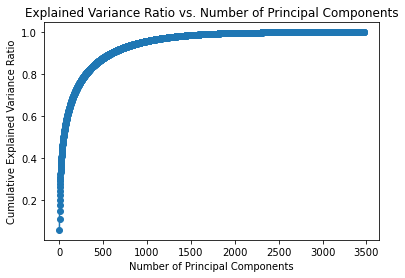

In [9]:
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.show()

In [10]:
pca = PCA(n_components= 1000)
X_pca = pca.fit_transform(X_std)

In [11]:
y = df1['Fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 4263)
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8524, 1000)
(2132, 1000)
(8524,)
(2132,)


In [68]:
print("Counts of label '1' in training data: {}".format(sum(y_train == 1)))
print("Counts of label '0' in training data: {}".format(sum(y_train == 0)))

Counts of label '1' in training data: 588
Counts of label '0' in training data: 7936


In [35]:
def resampling_method(method,X_train,y_train):
    if method == 'Undersampling':
        rus = RandomUnderSampler(random_state=4263)
        X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
    elif method == 'Oversampling':
        ros = RandomOverSampler(random_state=4263)
        X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
    else:
        print("Invalid resampling method")
    resampled_class_counts = pd.Series(y_train_balanced).value_counts()
    print("Resampled class counts:")
    print(resampled_class_counts)
    return X_train_balanced, y_train_balanced
        

In [37]:
model = LogisticRegression(max_iter = 500, random_state = 4263)
X_train_balanced, y_train_balanced = resampling_method('Oversampling',X_train,y_train)
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Resampled class counts:
0    7936
1    7936
Name: Fraudulent, dtype: int64
Accuracy: 0.9666979362101313
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1990
           1       0.76      0.73      0.74       142

    accuracy                           0.97      2132
   macro avg       0.87      0.85      0.86      2132
weighted avg       0.97      0.97      0.97      2132



In [40]:
def plot_confusion_matrix(y_test,y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix for {model_name}')

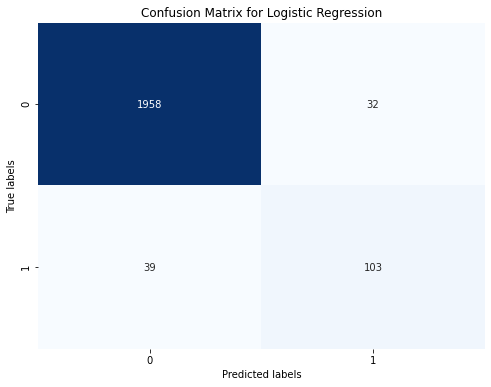

In [41]:
plot_confusion_matrix(y_test,y_pred,'Logistic Regression')

In [42]:
def auc_roc(model,model_name,X_test,y_test):
    pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    plt.plot(fpr, tpr, linestyle='--',color='orange', label=model_name)
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    auc_score = round(roc_auc_score(y_test, pred_prob[:,1]),3)
    return print(f'AUC score: {auc_score}')
    

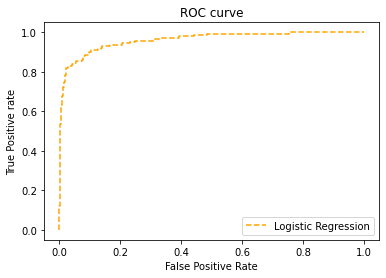

AUC score: 0.962


In [43]:
auc_roc(model,'Logistic Regression',X_test,y_test)